# Collaborative Filtering Recommender Systems

* $u \in Users$ - Пользователи, $|Users| = n$
* $i \in Items$ - Продукты, $|Items| = m$
* $r_{i,j} \in Ratings = Users * Items$ - Рейтинги,  $|Ratings| = m*n$

## Intro

Представим, что мы имеем онлайн-кинотеатр, в котором пользователи смотрят фильмы, ставят им рейтинги, пишут к ним рецензии итд. Нас попросили улучшить пользовательский опыт использования (experience) этого сервиса путем создания рекомендательной системы, которая будет рекомендовать фильмы,которые могут понравится пользователям, в виде списка. <br>
Выделяют следующие подвиды Collaborative Filtering: 
* User-Based
* Item-Based (Content-Based)

## User-Based 

Основная идея данного подхода заключается в следующем: пользователи, которым нравятся похожие продукты (фильмы, места, песни итд.) скорее всего имеют одиннаковые вкусы. И этой информации в принципе нам уже достаточно, чтобы дать рекомендацию пользователю. Ему можно рекомендовать что-то с чем он еще не сталкивался, но людям с похожими вкусами его оценили высоко. В данном случае мы учитываем **только рейтинги пользователей в системе**, мы не учитываем личные характеристики пользователей (пол, возраст, страна итд) и не учитываем характеристики самих продуктов.

P.S.
Для новых пользователей такой подход не сработает по той простой причине, что у них еще нет истории взаимодействий. Такая проблема называется **Cold Start Problem**. Мы не будем рассматривать такие случаи, но ее можно решить выдав популярные продукты в системе

In [39]:
import pandas as pd
from scipy import spatial

In [40]:
exmpl = pd.DataFrame(
    {
        'Movie1': [4, 4, 5, 3],
        'Movie2': [3, 5, 2, 5], 
        'Movie3': [2, 5, 4, None],
        'Movie4': [4, 2, 3, None]
    }, index=['User1', 'User2', 'User3', 'User4'])

In [3]:
exmpl

,Movie1,Movie2,Movie3,Movie4
User1,4,3,2.0,4.0
User2,4,5,5.0,2.0
User3,5,2,4.0,3.0
User4,3,5,NaN,NaN


Для **User4** не определен рейтинг для фильмов **Movie3** и **Movie4**. Однако, рейтинги фильмов Movie1 и Movie2 примерно похожи с **User1**. Можно сделать предположение, что **Movie3** окажется хорошей рекомендацией, а **Movie4** - нет.

Но давайте обозначим более формально, то как мы будем считать, что пользователи похожи друг на друга.

In [41]:
exmpl[['Movie1', 'Movie2']].values

array([[4, 3],
       [4, 5],
       [5, 2],
       [3, 5]])

No handles with labels found to put in legend.


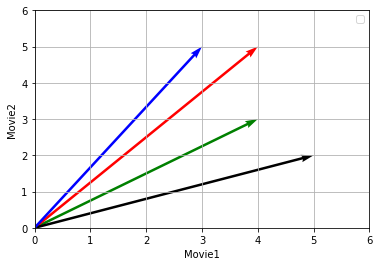

In [42]:
import matplotlib.pyplot as plt
import numpy as np

vectors = np.array(([2, 0], [3, 2]))
vector_addition = vectors[0] + vectors[1]
vectors = exmpl[['Movie1', 'Movie2']].values
 
tail = [0, 0]
fig, ax = plt.subplots(1)
ax.quiver(*[[0, 0, 0, 0], [0, 0, 0, 0]],
           vectors[:, 0],
           vectors[:, 1],
           scale=1,
           scale_units='xy',
           angles = 'xy',
           color=['g', 'r', 'k', 'b'])
 
ax.set_xlim((0, vectors[:,0].max()+1))
ax.set_xlabel('Movie1')
ax.set_ylim((0, vectors[:,1].max()+1))
ax.set_ylabel('Movie2')
ax.legend()
plt.grid()data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAXsAAAEKCAYAAADzQPVvAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAA+/0lEQVR4nO3dd3hU1dbA4d8OCQmhBSF0pEkTBKTX0OxdUexdsSBiF5B8FgIiYr+KBexYQAFRUcFASOhNQKSJKBB6hwDp+/tjzUwIJKQwk2nrvU+eO/vkZM46AovDnr3XMtZalFJKBbYQbweglFLK8zTZK6VUENBkr5RSQUCTvVJKBQFN9kopFQQ02SulVBDwaLI3xkQZY74zxqwzxqw1xnT25PWUUkrlLdTD7/8W8Ku19npjTGkg0sPXU0oplQfjqU1VxpgKwEqggdWdW0op5VWefLJvAOwBPjHGtAKWAYOstUdPPMkY0x/oDxAREdH27LPP9mBI3pOdnU1ISOB+RKL359/0/vzXhg0b9lprows6z5NP9u2AhUBXa+0iY8xbwGFrbWx+P9OkSRO7fv16j8TjbQkJCfTs2dPbYXiM3p9/0/vzX8aYZdbadgWd58m/6pKBZGvtIsf4O6CNB6+nlFIqHx5L9tbancBWY0wTx6E+wBpPXU8ppVT+PL0aZyAwwbESZxNwt4evp5RSKg8eTfbW2hVAgXNJSimlICMjg+TkZFJTU0/5XkREBLVr1yYsLKxY7+3pJ3ullFKFlJycTPny5alXrx7GGNdxay379u0jOTmZ+vXrF+u9A3MtklJK+aHU1FQqV66cK9EDGGOoXLlynk/8haXJXimlfMjJib6g44WlyV4ppYKAJnullAoCmuyVUsqH5FfV4EyrHWiyV0opHxEREcG+fftOSezO1TgRERHFfm9deqmUUj6idu3aJCcns2fPnlO+51xnX1ya7JVSykeEhYUVex19QXQaRymlgoAme6WUCgKa7JVSKghosldKqSCgyV4ppYKAJnullAoCmuyVUioIaLJXSqkgoMleKaWCgCZ7pZQKAprslVIqCGiyV0qpIKDJXimlgoAme6WUCgKa7JVSKghosldKqSCgyV4ppYKAJnullAoCHm1LaIz5DzgCZAGZ1tp2nryeUkqpvJVED9pe1tq9JXAdpZRS+dBpHKWUCgKeTvYWmGGMWWaM6e/haynlETt2eDsCD8rKgk2bvB2FKgHGWuu5NzemprV2uzGmKjATGGitTTzpnP5Af4Do6Oi2EydO9Fg83pSSkkK5cuW8HYbHBOL9ZWdLojcGKlQIsPvLzIS9e2HfPmjQgJSsrMC6v5ME4u9Pp169ei0r1Oeh1toS+QJeAJ463TmNGze2gWr27NneDsGjAun+srOtnTDB2po1rS1TxtqdOwPk/rKzrZ0719pbbrG2dGlrwdq4OGttgNzfaQTy/QFLbSFysMemcYwxZY0x5Z2vgYuA1Z66nlLusHIl9OgBt94K27fDAw9AtWrejuoMHTkCY8dCq1bQrRt89RWkp0P79vDss96OTpUQT67GqQZMMcY4r/OVtfZXD15PqWLbvx/+7/8kJ2Zny7HwcHj6ae/GdUb+/FNu6IsvICUl9/ciIuDzzyG0JBbkKV/gsV9pa+0moJWn3l8pd8jKgvHjYehQmb4+0b33Qs2a3onrjBw+DLffDtOm5X/OyJHQtGnJxaS8TpdeqqC1YAF06CBTNScn+rAwP57hqFABJkyAt96C0qVP/X6PHjBoUMnHpbxKk70KSikpMGMGlCqV9/fvvBPOPrtkY3K7OXNkbv5EZcvCJ59AiP7RDzb6K66CUrly8Pzz8PXXp34AW6oUDBninbjcYtMm6NwZJk+WcVRUzvdefx3q1/dKWMq7NNmroLVjB1x0EezaJeMyZeT/b70VGjTwXlxnJD5eVtmsdix8u+ACWWIUEgIXXwz33+/d+JTXaLJXQenAAcl9zs2jzzwjT/PGyIe1fsdamaO/+GJZWgTw+OPwyy8yH9Wjh3wSLavjVBDSdVcq6Bw7BldcISsTQVbdjBoFW7bAunXQpIl34yuy1FR46CH49FMZh4fDhx/CHXfknJPXfJUKKprsVVBJT4frr4f582V83XXw/vvywFu3Lrz7rnfjK7Lt2+UmFi2Scc2aMGWKLDM6kSb6oKfTOCpoZGfDXXfJzAZA796yQvHEfUUnfpbp8xYuhHbtchJ9p06wdOmpiV4pNNmrIGEtPPqozGaA5MipU2UjqV/69FOZh3eW5LznHkhIgBo1vBmV8mGa7FVQePHFnCmapk3l6b58ee/GVCyZmfDYY3D33TInVaoUvPMOjBsnc/VK5UPn7FXAe/ttSfYAderIZqoqVbwbU7Hs2wf9+sGsWTKuXBkmTpT5KKUKoMleBbQJE3IqA1SpAjNnSsL3O3/+CVdfDf/+K+OWLWUeSjdIqULSaRwVsH7+WcoegOyY/fVXP1xWCbITtnPnnETfty/Mm6eJXhWJJnsVkJKSZIllVpZMZU+bBm3bejuqIsrOlpoOffvC0aNybPhwmDRJ/vZSqgh0GkcFnJUr4corZa9RSAh88w306uXtqIroyBEpU/zDDzIuXx6+/BKuusq7cSm/pcleBZSNG6ViwKFDMh43Dq65xqshFd3GjRL0X3/J+JxzJOmfe65Xw1L+TadxVMDYvh0uvDCnsNmYMbJC0a/MmCGFzJyJ/qKLYPFiTfTqjGmyVwFh/37Ji//9J+PBg+HJJ70aUtFYC2+8AZdeCgcPyrGnnpJPmStV8mpoKjDoNI7ye0ePwuWX5zwM33+/dN3zG8ePS7usL76QcXi4zD/ddpt341IBRZO98mvp6VIHbOFCGV9/vfTY9ptKvtu2wbXXwpIlMq5VS9bPt2vn1bBU4NFpHOW3srKkiu+MGTK+4AJZsJJfq0Gfs2CBJHVnou/SRQqZaaJXHqDJXvkla+GRR+Dbb2XcoYNU9vWb8jDjx0PPnrBzp4zvu0/KIFSv7tWwVODSZK/80v/9n9ShB2jWDKZP95N9RhkZMHCgJPf0dKmv/O670mzEb/6mUv5I5+yV33nzTYiLk9dnny3TOJUrezWkwtm7F264QUoRgxTrmTRJnvCV8jBN9sqvfP65tFYFiI6Wwma1a3s3pkJZuVI2SjnXhrZqJRul6tb1ZlQqiOg0jvIb06ZJjw6Q6gG//gqNG3s3pkKZNEk+fHUm+n79pJCZJnpVgjTZK78wZ47kSGdhsx9/hDZtvB1VAbKzITZWAj92TNaDjhwpxXrKlvV2dCrI6DSO8nl//CH1v9LSZFnlxInSkc+nHT4sm6J+/FHG5cvDV1/BFVd4Ny4VtDye7I0xpYClwDZrrf5OV0WyYYMUNjt8WMYff+wHhR///lsajaxdK+NGjWR+vlkz78alglpJTOMMAtaWwHVUgElOlno3e/bI+PXXZROVT/vtN1n070z0l1wihcw00Ssv82iyN8bUBi4HxnnyOirw7NsnT/SbN8v4uedyVuH4JGvh1VfhsstyCpk9+yz89BNERXkzMqUAMNZaz725Md8BLwPlgafymsYxxvQH+gNER0e3nThxosfi8aaUlBTK+cWun+Jx5/1lZ8v0jbM5U3S0rKf3ptPen7Wy0mb/fhkbA/XqwVlnlVR4Z0x/f/qvXr16LbPWFlxjw1rrkS/gCuA9x+uewE8F/Uzjxo1toJo9e7a3Q/Aod91faqq1F15orWRQa/v1szYz0y1vfUbyvb8tW6xt2zYn4Dp1rF26tERjcwf9/em/gKW2EDnZk9M4XYGrjDH/Ad8AvY0xX3rwesrPZWVJJ76ZM2V80UVS9ddnC5vNnStFy5Ytk3G3blLIzO+a3apg4LFkb60dYq2tba2tB9wEzLLWaoFulSdr4eGHZf8RQKdOMHkylC7t3bjy9dFH0Ls37N4t4wcegPh4qFrVu3EplQ/dVKV8wnPPSS0wgObNpUGTT+47ysiAAQOgf395HRoqBfTff9+H/2ZSqoQ2VVlrE4CEkriW8j+vvQYvvyyv69WT1Ys++dnm7t1SyCwxUcbR0fD999C9u3fjUqoQdAet8qpPPpFWqyAzIDNmSLMmn3P8uDQC37JFxuefLx2lvL1MSKlC0mkc5TVTp0pZd4AKFeSJvlEjr4aUt2+/hXXrchL9TTfJh7Oa6JUf0WSvvCIhQXJmdjZERMjeo9atvR3VSbKyYOjQnECNgVdekRo3kZHejk6pItFpHFXili3LXdhs0iQfnPY+dAhuuUVaYIEE+tNPskNWKT+kyV6VqPXrpVzMkSMy/vRTHywEuX69FDJbv17GTZpIbZuLL/ZuXEqdAZ3GUSVm61a48ELpzgfw1ltSBdinTJ8uhcycif7yy2HRIu0Pq/yeJntVIvbulR2xW7fKODYWHn3UuzHlYq3Mx19xRU495SFDpDRxxYrejU0pN9BpHOVxR47IVPe6dTJ++GF48UXvxpTLsWNw773SQQqgTBlZE3rjjd6NSyk30mSvPCotDa69FpYskfFNN8E778jCFp+wZYs0Av/jDxmffbY8zfvc0iClzoxO4yiPycqSBS3x8TK+5BL47DMI8ZXfdYmJUsjMmehjYqSQmSZ6FYB85Y+dCjDWSm2wyZNl3KULfPedD5WPef996NMnpw3Www/D779LCQSlApBO4yiPGDIExo+X1y1ayBJ1nyhslp4unwx/8IGMw8Lg3Xfh/vu9G5dSHqbJXrndq6/KwhaA+vWl3k2lSt6NCYBdu+D666XUAUgxnsmToWtX78alVAnQZK/cavx4eOYZeV2tmjQiqVHDuzEBsm33mmukizlIg5EpU6BOHa+GpVRJ0Tl75TaTJ0uZd5Cl6TNmQMOG3o0JkFo23brlJPpbb4WkJE30KqhoslduceQI3Hyz1AsrU0bm6Fu29HJQWVnw7LOS3FNTZRnQq69Kr8MyZbwcnFIl67TJ3hhTxxjzjTEmyRgz1BgTdsL3pno8OuUXliyBjRvls8/QUFl1062bl4M6cEB2w44eLeOoKCmF8NRTPrTIX6mSU9CT/cdIh6mBQA1gjjGmsuN7dT0Yl/IT69bBpZfKEz3IOnqvF4ZcuxY6doRff5Vxs2aweLEWMlNBraBkH22tfd9au8JaOxB4D0g0xjQErOfDU75syxYpbLZvn4zfeUc2UXnVTz9Jov/7bxlfeSUsXOijXVGUKjkFJfswY0yEc2Ct/RIYBPyGPOmrILVnjxQ2c37mWbMmPPKIFwOyFkaOlEL5zvrJw4ZJO6wKFbwYmFK+oaBkPw7oeOIBa+3vwA3Aak8FpXzb4cMydeOsAvzII15eXnn0qBQte+45SfqRkdIRZfhwH6rNoJR3nXadvbX2jXyO/wFc6JGIlE9LTZXl6suWyfiWW6QufWKilwL67z8JaOVKGderJ0/zrVp5KSClfFOhHnuMMY2NMfHGmNWOcUtjzDDPhqZ8TWamLK+cPVvGl10mnaa89vCckADt2+ck+l69ZGmQJnqlTlHYP6YfAUOADABr7SrgJk8FpXyPtbJhaupUGXftKjMlYWGn/THPBfPuu3DBBTltrwYOhN9+gypVvBCQUr6vsOUSIq21i03u9cmZHohH+SBrpQTCJ5/IuGVLWfQSGemFYNLS5EOCceNkHBYGY8dK8xGlVL4Km+z3nrjc0hhzPbDDY1EpnzJ6NIwZI68bNpQH6KgoLwSycyf07Qvz58u4enWp0dC5sxeCUcq/FDbZDwA+BJoaY7YB/wK+1ipaecBHH8HgwfK6Rg2pd1O9uhcCWbJEWl5t2ybj9u2lkFmtWl4IRin/U6hkb63dBFxgjCkLhFhrjxT0M471+YlAuOM631lrnz+TYFXJ+u47ePBBeR0VJU/0DRp4IZAvv4T77pMpHIDbb4cPP4SIiNP/nFLK5bTJ3hhzm7X2S2PMEycdB8Ba+/ppfjwN6G2tTXHU1JlrjPnFWrvwTINWnvf771I/zFnY7Oef4bzzSjiIzEz5Z8Vrr8k4JETmkx57TOvbKFVEBT3ZO3sLlS/qG1trLZDiGIY5vrTEgh9YvFiWrjsLm02eLG0FS9SBA9KdfMYMGVeqBN9+K/UZlFJFZiQnF3CSMdHW2j1FfnNjSgHLgHOAd621z+ZxTn+gP0B0dHTbiRMnFvUyfiElJYVy5cp5O4wCpabKzthMx1qrBg0K12XKrfeXmiplNJ3TNhERcM45EB7unvcvBn/59StIls0iNTOV4xnHSc1MJS0rjeplq2PTbUDcX34C5dcvL7169VpmrW1X0HmFTfZ/Ix/KfgtMttYeKEowxpgoYAow0Fqbb5mFJk2a2PXOPfgBJiEhgZ49e3o7jNPavFnWzzs/A33vPXjoocL9rNvu74cf4LbbIMXxj8JrroHPP4fyRf7HpVv5w6/fifYc3cOaPWtcX2v3rmXNnjXsSMlZRBcZFsnkfpO5+JyL/e7+iiqQ788YU6hkX9gPaBsZYzogG6meM8asAb5xFEYrzM8fNMYkAJegNXV80u7dMkPiTPQvvVT4RO8W2dkwYgT83//lHHv+eRlrfZtCy8zO5IEfH+DjFR+f9rxKEZWYfut0OtXuVEKRKW8r9J8ia+1ia+0TQAdgP/DZ6c43xkQ7nugxxpQBLgDWFT9U5SmHD8Mll+RUBR40SApGlpiUFOjXLyfRly0L338PL7ygib6IQkNC+eiqj3i5z8v5nlOzfE2S7k7SRB9kCvVkb4ypAFyLPNk3RKZkOhTwYzWAzxzz9iHARGvtT2cQq/KA48elKvAff8j4ttvg9ddLcLHLv//C1VfDn3/KuH59mcop8aU/gSErO4tJayYx4c8JeX7/nLPOYebtM6kXVa9kA1NeV9hNVSuBqcBL1toFhfkBR/2c84sZlyoBmZmy4GXOHBlfcQV8/HEJPkzPmgU33AD798u4Tx9ZcVO58ul/Tp0iMzuTr/78ipFJI1m/L+/PvVpXb82vt/5KtXLVSjg65QsK+8e6gbX2cWC1MSYwP9IOMtnZsk9p2jQZd+8OEyeWUGEza6Wt1UUX5ST6xx6TNoKa6IskPSudj5Z9RON3GnPn1Dtdib5ymcrE9YpzPcHH1I0h4c4ETfRBrLBP9s2NMV8AZwHGGLMHuPN0K2uU77JW+m5/5vjUpVUr+PFH2TzlcWlp8smvs6pa6dLwwQdw110lcPHAkZqZyrjl43hl3iskH052Ha9WthpPdXmKB9s9SLnS5fhs5Wdc1eQqvun7DWXCSuIXWPmqwib7D4EnrLWzAYwxPR3HSnqrjXKDl1+GNxxtac45R8ogVKxYAhfesQOuu056woIU25kyRXrGqkI5mn6UD5Z9wKvzX2Vnyk7X8Vrla/FM12e4v839uZL6Ha3uYHC3wYSGFPaPugpUhf0dUNaZ6AGstQmOOjnKz3zwgXTvA+kbO3MmVCuJf9kvXiyFzLZvl3HHjrI1t2bNEri4/zucdph3F7/L6wtfZ++xva7j9aLqMbjrYO5qfRfhoaduOhsWoz2GlChsst9kjIkFvnCMb0M2WSk/MnFiztr5SpXkib5evRK48GefwQMP5OyIvesuqUGvhcwKdOD4Ad5e9DZvLXqLA6k5exkbndWIod2Hcut5txJWyhsdZJS/KWyyvwd4EZgMGKSa5d2eCkq534wZsqzSWlnGPn06tGjh4YtmZsLTT8Obb8q4VClZ1zlwoBYyK8Ceo3t4Y+Eb/G/x/ziSnlNk9tzoc3mu+3P0a95Pp2ZUkRR2B+0B4FEPx6I8ZOFCmUHJyJDVNpMnQydP76fZtw9uvBHi42V81lnyT4s+fTx8Yf+248gOXlvwGmOXjuVYxjHX8VbVWhEbE8u1za4lxOhGM1V0BZU4nna671trr3JvOMrd/vpLGoMfOyYP019+KSsePWr1atkotWmTjFu0kI1SXimG7x+2HtrK6Hmj+Wj5R6RlpbmOt6/ZntiYWK5ofIWrtLhSxVHQk31nYCvwNbAImcJRfuK//ySxH3BM9Y4dK1UJPGrKFGkucvSojK+7TubsA7Ti4JnadGATo+aO4tMVn5KRneE63u3sbsTGxHJhgws1ySu3KCjZVwcuBG4GbgF+Br621v7l6cDUmdm1SwqbORe/jBghn5F61IsvSj0bp5dekqU/Wt/mFOv3rufluS/z5aovybJZruN96vdhWMwwetTtoUleudVpk721Ngv4FfjVGBOOJP0EY8xL1tp3SiJAVXSHDklhs40bZfzEEzBkiAcveOQI/PNPTqIvVw6++ELKE6tcVu9ezYikEXy7+lvsCb18Lmt0GcO6D6NzHW2erjyjwA9oHUn+ciTR1wPeRlblKB90/DhceSWsWCHjO++EV1/14OKXf/6R+fm7HYuzGjaU+fnmzT10Qf+0fMdy4hLjmLJuSq7j1zS9hmHdh9G2ZlsvRaaCRUEf0H4GtAB+AV7U8gi+LSND5uSTkmR81VUwbpwHZ1F+/10u6PxQ4MIL4ZtvZOWNAmBh8kLiEuP4+e+fXccMhn7N+zG0+1BaVmvpxehUMCnoyf524CjQGHj0hDlEg7SZreDB2FQRZGfDPffAT44i0j16SAHJUE8sxbZW1s4/9ZRcGGQb7vTpHrqg/0ncnMjwxOH8vul317FSphS3nHcLQ7sPpWmVpl6MTgWjgubs9ZM1P2CtzMt/6egb1qaNVLP0yAbV1FT5pPfzz2UcHg4ffQS1awd9orfW8vum3xmeOJykLUmu42EhYdzZ6k4GdxtMw7MaejFCFcyC+09ngBgxAt56S143bgy//AIVPPFvrm3bZCnl4sUyrlkTpk6F9u0hIcEDF/QP1lqm/z2d4YnDWbRtket4eKlw7j3/Xp7t9ixnVzzbixEqpcne740dC7Gx8rpWLSmLULWqBy60YIEk+p2OSoudO0vrwBo1PHAx/5Bts5m6bipxiXH8sfMP1/EyoWV4sN2DPNXlKWqW10Jvyjdosvdj33wDAwbI67POkkRft64HLvTJJ/Dgg5CeLuN774V335UpnCCUlZ3FxL8mMiJpBH/tydlyUq50OR5p/wiPd36cqmU98TeuUsWnyd5P/fqrbFR1Fjb75Rc491w3XyQjQz6EffttGZcqJR/MDhgQlIXMMrIypPXf3JFs2LfBdbxieEUGdRzEoE6DOKuMrkRSvkmTvR+aP19mVDIzpdHT1KnQoaD270W1d68sq5ztaGNQuTJMmgS9ern5Qr4vLTONvcf20uR/Tfj3YE5l78plKvNE5ycY0H4AFSNKovuLUsWnyd7P/PknXH65bJ4KCYGvvoILLnDzRVatko1S//0n45YtZaNUiRS/9x3HM44z/o/xvDLvFR6r/pgr0VcrW42nuzzNA+0eoFxprfmj/IMmez+yaZMUNjt4UMbvvw99+7r5It9/D3fcIWUyAa6/Hj79VOaKgsTR9KO8v/R9xiwYk9P6r7q0/nu267Pc1+Y+7eeq/I4mez+xc6dsUHUuhhk1Cu6/340XyM6W2jbDh8vYGHk9dGjQzM+frvVf3Yp1+eeGf/Js/aeUP9Bk7wcOHoSLL84pD//UU/DMM268wOHD8mnvNEf7gvLlYcIEKbITBPYf3+9q/Xcw9aDr+Imt/+YlzdNEr/yaJnsfd+wYXHGFTKODlEQYPdqND9sbN8r8/Jo1Mj7nHEn6zZq56QK+a8/RPby+4HXeXfLuKa3/hnUfRr/m/SgVUsqLESrlPprsfVhGBtxwA8ybJ+NrroEPPnBjov/tN7jpppwPAS6+GL7+WrqRB7AdR3YwZv4Y3l/2fq7Wf62rt2ZY92Ha+k8FJE32Pio7G+66S2qLgax4/PprN5WfsVYafz/zTE4hs6efhpdflrX0AWrroa28Mu8Vxi0fl6v1X4daHYiNieXyRpdrwxAVsDyW7I0xdYDPkW5X2cCH1tq3PHW9QGItDBokyyoB2raVtfRuKWx2/Dj0759TNS0iQuog33qrG97cN206sImXk17ms5Wf5Wr91/3s7sTGxHJBgws0yauA58kn+0zgSWvtcmNMeWCZMWamtXaNB68ZEF56Cf73P3ndpIkbC5slJ8O118LSpTKuXVv+FmkbmI0z1u9dz8i5I5mwakKu1n8XNLiAYd2H0aNeDy9Gp1TJ8liyt9buAHY4Xh8xxqwFagGa7E/jnXdyuvvVri31bqKj3fDG8+bJovxdu2Tctausqa9WzQ1v7lv+3PUnI5JGMPGvidr6L8Ds27ePQ4cOERkZSZkyZYiMjCQsLMzbYfkFY60t+KwzvYgx9YBEoIW19vBJ3+sP9AeIjo5uO3HiRI/H4w0pKSmUK3f63Zb798O/jt34oaHyVO+WqZu9e2HLFpkfAqhSBc4+263r5wtzf552LOMYO1J25Fo+CRAVEUWNcjWIDIss9nv7wv15kr/cX2ZmJuvWrSMtLS3X8ZCQkDy/wsPDqVWrFmlpaX5xf8XRq1evZdbadgWeaK316BdQDlgGXFfQuY0bN7aBavbs2af9/s8/Wxsaai1YW66ctUuWuOGi6enWDhggbwpygffeszY72w1vnltB9+dJC7YusJdNuMzyAq4v84KxN0660a7aucot1/Dm/ZUEf7q/9evX20qVKlkg36+QkBA7YMAAe+DAAWutf91fUQFLbSFysUdX4xhjwoDvgQnWWm1Sno+5c2WGxVnY7IcfoF3Bf0+f3p49sm5zzhwZV6ki0zYxMWccr6+Y898chicOJ/7feNexUqYUt7a8laHdhtKkShMvRqfcad++fSQkJBAfH8+sWbM44Ox7nIcOHTowduxY2rRpU4IR+j5PrsYxwHhgrbX2dU9dx9+tXCmbplJTpbDZN99A795n+KYrVsii/M2bZdy6tXwQ65Fi9yXLWsvMTTOJS4w7pfXfXa3vYnC3wTSo1MCLESp3SElJISkpyZXcV6xY4ZwpyFelSpUYNWoU9913HyEhuk/iZJ58su+KNCz/0xizwnFsqLV2ugev6Vf++Uf2MR06JOOPPpLFMmdk4kRZoH/8uIxvvBE+/hgiiz9f7Qustfz898/EJcad0vrvvjb38UzXZ7T1nx9LS0tj4cKFruS+aNEiMjMzTzmvdOnSdO7cmVatWvG2s88CcM899zBq1Cii3bKaITB5cjXOXEAXL+dj+3YpbOZcHDN6tJRCKLbsbOlPOHKkjI2R188+69eFzLJtNlPWTiEuKY4VO1e4jkeGRfJgW2n9V6N88LZG9FdZWVksX77cldznzp3LcecDyglCQkJo27YtvXv3pk+fPnTt2pXIyEimT5/O22+/TcuWLRk7dixdunTxwl34F91B6wUHDsgTvXPlzbPPygbWYjt0CG67DX76ScYVKsiOrMsvP+NYvSW/1n/lS5fnkQ6P8Hinx4kuq09x/sJay5o1a1zJPSEhgUPOf9KepHnz5q7k3qNHD6Kiok45Z926dbz55psMGDCAULdsKw98+l+phB09Kjl49WoZ33efVCkotg0b4KqrYP16GTduLJ/wNm16xrF6Q0ZWBhP+nMDIpJH8vf9v1/GoiCgGdRzEox0f1dZ/fuLff/91JfdZs2axy/nP2JPUr1/fldx79epF9erVC3zvQYMGUSqAS3t4gib7EpSeLr1AFiyQ8XXXSQOSYs+y/PIL3HxzzqT/ZZdJaeI8noR8XVpmGp+u+JRR80bx38H/XMerRFbhiU5PMKDDACqEu2MbsfKUnTt3uhL7rFmz+Pfff/M8r1q1aq7k3rt3b+rXr1/ka2miLzpN9iXozjulUThAnz4y01Ks37PWwquvwuDBORulBg+GuDi/K2R2POM445aPY/T80SQfTnYdd7b+e7Ddg5QtHTxdsvzJwYMHSUhIYNasWcTHx7NmTd6b4ytWrEjPnj1dyf3cc8/VWkReoMm+BFgrG1i/+UbG7dvDlCkQXpxeGMeOydzP11/LuEwZGD9envD9SEp6irT+mz+GXUdz/nlfu0Jtnu36LPeef6+2/vMxx44dY968ea6pmWXLlpHtrJp6gjJlytCtWzdXcm/Tpo0+ifsATfYl4PnnoWJFed2smZQtLl++GG+0ZYuszVy+XMZ16sj6eT/aPHIo9RDvLnmX1xe8zr7j+1zH60fVZ0i3IdzR6g7tCOUjMjIyWLx4sSu5L1iwgPT09FPOCw0NpWPHjq7k3qlTJ8KL9SSjPEmTvYe99Za0ch0zRsrRzJghm1mLLClJJvx375Zx9+7w3XdQtapb4/WU/cf389bCt3h78du5atc0rtyYod2Gcst5txBWSgtaeVN2djYrV650JffExESOHj16ynnGGFq3bu1K7t27dw/YujOBRJO9B33xBTz2mLwODZVEX7t2Md7ogw/gkUekngLAQw/Bm29KbQUft/voblfrv5T0FNfx5tHNGRYzjBvOvUFb/3mJtZYNGzYQHx9PREQEffv2Zf/+/Xme26RJE1dy79mzJ5UrVy7haNWZ0mTvIT/+CHffLa/Ll4dGjaSKZZGkp0sXk/ffl3FoqBS6f+ABt8bqCTuO7ODV+a/y/tL3OZ6Zs1nm/OrnMyxmGNc0vUZb/3nB1q1bXU/u8fHxbN++HYAxY8bkSvR16tRxJffevXtTq1Ytb4Ws3ESTvQckJkK/fpCVJR/CTptWjDfZvVumbZIc9V+io6WQWffubo3V3bYc2sIrc19h/B/jc7X+61irI7ExsVzW6DJdiVGC9uzZw+zZs13JfePGjXmeFxoaSr9+/VxLIhs2bKi/TgFGk72brVgBV16ZU9js22+hZ09ISCjCmyxfLoXMtm6VcZs2snznbN+t/ZKWlcb90+4/pfVfTN0YYmNi6VO/jyaPEnD48GESExNdyX3VqlV5nleuXDl69Ojheno/cOAAgwYNKuFoVUnSZO9Gf/8tZRAOO9qzjB8PV19dxDf55hspkuOsE3LLLVIhzUcLma3bu46RSSNpldqKcRvGuY5f0OACYmNiiakbOCWVfVFqairz5893JfclS5aQlZV1ynnh4eF06dLFldzbtWuXq8NTQpGeRpQ/0mTvJtu2SWEz52KZ116T4pOFlpUFzz0Hr7wiY2Pk9VNP+WQhsz93/UlcUhyT/pqExdKqcSsALm90OcNihtGpdicvRxiYMjMzWbp0qSu5z5s375SuTSAFxNq3b+9K7l26dKFMGd23EMw02bvB/v3yRO8sHz9kCDzxRBHe4OBBeYL/5RcZV6wom6YuvdTdoZ6xZduXEZcUx9R1U3Mdj4qIYnn/5Zxf43zvBBagsrOzWb16tSu5z5kzhyNHjuR57nnnnedK7jExMVR0bu5QCk32ZywlRUrS/OUozNi/P4wYUYQ3WLdO5no2bJBx06ZSyKxxY7fHeiYWbF3A8MTh/LLxF9cxg+HGFjfyXPfn2LtmryZ6N7DW8s8//7iS++zZs9mzZ0+e5zZs2NCV3Hv16kVVP9lzobxDk/0ZSEuTdoKLHL00brgB3nuvCLMuP/8sT/TOSf7LL5dCZj7yRGatZc5maf03699ZruOlTClua3kbQ7oNcbX+S1iT4KUo/d/27dtdyX3WrFls2bIlz/Nq1KiRazlk3QDoPKZKjib7YsrKgjvukI1SIPP1X3xRyDpk1sKoUTJH7yxkNnQovPSSTxQyc7b+G544nLlb5rqOa+s/99i/f3+ufqrr1q3L87xKlSrRq1cv13LIJk2a6IomVWya7IvBWhgwQDoAAnTsCJMnF7Kw2dGjcO+9siYTZJXNJ5/Iwnwvs9by04afiEuKY/G2xa7j4aXCub/N/TzT9RnqVKzjxQj9U0pKCnPnznUl9z/++CPPfqqRkZHExMS4knurVq20gJhyG032xRAbKxUMAM49V2ZjClUaZPNmWT+/YoWM69aVQmatW3skzsLKttlMXjuZuMQ4Vu5a6ToeGRbJQ+0e4snOT2rrvyJIS0tj0aJFruS+cOHCPPuphoWF0blzZ1dy79ChA6X9oASG8k+a7IvojTdyPoCtW1emcQpVJiQlBdq1g717ZdyjB0yaJDtjvSQzO9PV+m/Nnpxa5Nr6r2iysrL4448/XMk9KSkpz36qxphT+qmWLau1+lXJ0GRfBJ99lrOkMjoaZs6EAkuGWCu1bY4fz0n0jzwCr78OYd6p8piRlcGXq75k5NyRbNyfs30+KiKKxzo+xqMdH6VSmUpeic0fWGtZu3Ztrn6qBw8ezPPcc889N1c/1UqV9L+r8g5N9oU0bZpMtYP08/7tNyludlrp6ZLYP/pIahyHhclynfvu83i8eTld678nOz/Jw+0f1tZ/+UhPT2f8+PGulns7d+7M87y6devSp08fVz/VGjV0+kv5Bk32hTBnTk5hs4gIqWh5fkFLynftknWZ8+bJOCwMZs+Grl09Hu/Jjmcc56PlHzF63mi2HdnmOl69XHWe7vI0D7R9QFv/nWTXrl2uxB4fH8+AAQN46qmnTjmvatWqufqpNmigq5SUb9JkX4Dly6WwWVqarIqcOBFiCir3snSpdJRKdvRUbddOWlSVcKJPSU9h7JKxvLbgtVyt/+pUqCOt/9rcS0RoRInG5KsOHjzInDlzXMn9L+cuuZNUqFAhVz/V5s2b63JI5Rc02Z/Ghg1wySXg3J3+8ceS+E9rwgSZpklNlfFtt8GHH+bsvCoBh1IP8b/F/+ONhW/k2frvztZ3UrpUcK/6cPZTdSb3/PqpRkRE0K1bN2rVqsWiRYto06YNoaH6x0b5H/1dm4/kZNko5dyp/sYbsokqX1lZMHiwzM2D1DcePVo+0S2hJ7/9x/fz5sI3eXvR2xxKO+Q63rhyY57r/hy3nHcLoSHB+Uvu7KfqTO6n66faoUMH15N7586dCQ8PJyEhgQ4dOnghcqXcIzj/5Bdg3z646CLp7w0wbFhOe8E8HTgAN98sn9oCREXJpqmLLvJwpCK/1n8tqrZgWPdhXH/u9UHX+s/ZT9WZ3PPrpwqc0k+1fLG6wSvl2zyW7I0xHwNXALuttS08dR13O3JECputXSvjBx+UKgb5WrNGCpk5OwA1ayZLd845x+Oxbj+ynVfnvcoHyz44pfVfbEwsVze9Omha/zn7qZ5YQCy/fqqNGzd2fajas2dPqhSrA7xS/sWTT/afAv8DPvfgNdwqLQ2uuw4WOyoF3HijtHzNdxbmxx/h1ltzJvWvukoK5FTw7PLFzQc388o8af2XnpUzFdGpdidiY2K59JxLg+JDw61bt+YqILZt27Y8z6tdu3auAmK1i9X1XSn/5rFkb61NNMbU89T7u1tWlnyW+vvvMr74Yvj883zqklkLI0dK3QRnjZPYWHjhBZmr95CN+zcyau4oPlv5GZnZOdvve9TtQWxMLL3r9w7oJL9nz55cBcT+/vvvPM+rXLkyvXr1cq13P+eccwL6v4tShaFz9ki+fugh+O47GXfqJL298yxTkpICd9+dc3JkpGytvf56j8W3ds9aRs4dyVd/fkW2zVkxcmGDC4mNiaV7Xd9uQl5cR44cITEx0ZXcV65cmed5zn6qzif3li1bEuLBv3SV8kcmr+p7bntzebL/6XRz9saY/kB/gOjo6LYTnaUkS9C2beDcEFmmDDRpks8TfXq6zM07656ULi1z84Vo95aSkkK5QlVLy3E88zg7juzgQOqBXMcrhlekRvkalA3znY1Qxbm/k1lrSUlJ4ciRIxw+fDjfD1SNMZQrV47y5ctToUIFIiMjPf7k7o7782V6f/6rV69ey6y17Qo80VrrsS+gHrC6sOc3btzYlrRXX7VWnu2trVfP2m3b8jlx1ixrK1fOOblXL2v37Cn0dWbPnl3oc5dsW2Kv/vpqywvk+rru2+vs8u3LC/0+Jako9+eUkZFhFy5caEeMGGH79OljIyIiLHDKV0hIiO3QoYMdMmSInTlzpj127Jj7b6AAxbk/f6L357+ApbYQ+TWop3E++QSeflpeV6smhc1q1jzpJGvlU9rHH5eJfYBHH82pdeNG87fOZ3jicH7d+KvrWIgJ4cbm0vqvedXmbr1eScvOzuavv/5yTcvMmTOHw84uXSdp0aKF60PVHj16aD9Vpc6QJ5defg30BKoYY5KB56214z11vaKaOjWnHlnFirJE/pTVkmlp8PDDsnUWZNrm/fdlzt5NrLUk/JdAXFLcKa3/bm91O0O6DaFxZd/qR1tY1lo2bdrkSu6zZs3Kt59qgwYNcvVTrVatWglHq1Rg8+RqnJs99d5navZsWVaZnZ1T2KxVq5NO2rFDCpktWCDj6tVhyhT59NYNrLXM+GcGwxOHM2/rPNfxsJAw7m59N4O7DaZ+pfpuuVZJ2r59O7NnzyY+Pp74+Ph8+6lWr14913LIevXqlWygSgWZoJvGWbpUlsOnp8uHsN99B91PXsyyeLEUMtu+XcYdOkjfwQKL1xfMWsuPG34kLjGOJduXuI5HhEa4Wv/VruA/68D379/PnDlzSElJ4dxzz2WtczfaSaKionL1U23atKkuh1SqBAVVsl+3Di69VFZPgqyYvPzyk076/HPo31+mcADuvFOmbiLOvDrkpL8mMSJpxCmt/x5u9zBPdnmS6uWqn/E1PO3o0aOufqrx8fGufqpjxozJlegjIyPp3r27K7m3bt1a+6kq5UVBk+y3bpVSNc5mUW+9JZtfXTIz4dlnpYMUyOao116DQYPOqJBZZnYm367+loN7DvLInEdcx8uXLs/ADgN5vPPjVIn03e366enpp/RTzcjIOOU8Y0yu5N6xY0ftp6qUDwmKZL93ryT6rVtl/H//JwtqXPbvh5tukuU4AJUqSeH6Cy4o9jUzsjL4YtUXvDz3ZTbu38iYxlINs1JEJR7r9BgDOwz0ydZ/WVlZrFixwvXkPnfuXI4dO3bKecYY2rRp40ruYWFhPOHs2aiU8jkBn+yPHJGpm3XrZDxggFQ1cPnrL5nE37RJxs2bww8/QMOGxbpeWmYan6z4hFFzR7H50GbX8dCQUF7u87LPtf6z1rJu3bpc/VQPHDiQ57nNmjXL1U/1rLPOcn0vISGhhCJWShVHQCf71FS45hr5UBakCvHbb58wKzN1Ktx+e84k/rXXykR+MUrcHss4xkfLPmL0/NFsP7LddbxGuRo83eVpzks9j97dep/R/bjL5s2bXU/up+unevbZZ+fqp1rzlE0ISil/EbDJPjMTbrkFZjmWrl96KXz6qaNOWXY2xMXB88/n/MALL0gxsyLWVHG2/huzYAy7j+52Ha9ToQ6Duw3mnvPvISI0wqtPvrt27WL27NmuCpGbnP+KOUl0dPQp/VR1xYxSgSEgk721Uod+yhQZd+kiSyxLl0ae4u+8U5ZSApQtK2WJr722SNc4lHqIdxa/wxsL32D/8Zy66Q0qNWBItyHc0eoOr7X+O3ToUK5+qqtXr87zvAoVKtCjRw9Xcm/RooUmd6UCVEAm+8GDYbxjr+5558FPP0lxSjZtkkYjzuTXoIHMz7cofG+Vfcf28ebCN3ln8Tu5Wv81qdyE57o/x83n3Vzirf+OHz+eq5/q0qVL8+2n2rVrV1dyb9u2rfZTVSpIBNyf9NGj5Qskl//2myyuIT4e+vWTlTcgK22+/RZO+JDxdHal7OL1Ba/z3tL3crX+O6/qeQyLGUbfZn1LrPVfRkYGS5YscSX3+fPn59lPtVSpUqf0U41ww34BpZT/CahkP26cLJUHqW4wcybUqG7hrbfhySdzCpk9/rj8jVCIp9pth7fx6vxX+XDZh7la/7Wp0YbYmFiuanKVx1v/ZWdns2rVqlz9VFNSUvI8t1WrVq7kHhMTo/1UlVJAACX7yZPhgQfkdVSUPNE3qJkK9zwkn8wChIfDBx/InH0BNh/czKi5o/h4xce5Wv91rt2Z2JhYLjnnEo/Nb1tr+fvvv3P1U923b1+e5zZq1ChXATHtp6qUyktAJPv4eFlWmZ0tfUR++glaVtkOPa+DRYvkpBo15BPbjh1P+14b92/k5aSX+XzV5yXa+i85OTlXP9Xk5OQ8z6tVq1auAmJ16tRxeyxKqcDj98l+yRJZS5+eLrMy338PXUsthHbXSeVKyOkzeJp14mv3rGVE0gi+Xv11rtZ/FzW8iGHdh7m99d/evXtz9VPdsGFDnuedddZZufqpNmrUSFfMKKWKzK+T/dq1OYXNjJEaZpfu+hSueUCyP0jt+bFjZQonDyt3rmRE0gi+W/MdlpwWjVc2vpJhMcPoUKuDW2LNzs5m+vTpruS+YsWKPM8rW7Zsrn6qrVq10n6qSqkz5rfJfssWqXfjnMp+580sbl70pFQ4A6lf/MYb8MgjeRYyW7JtCXFJcUxbPy3X8b7N+jIsZhitq7c+o/hSU1NZuHChK7n37duXJ5988pTzSpcuTefOnV1TMx06dCDMzR2wlFLKL5P9nj1w4YXgnNZ+8dljDPjhypztsmedBZMmQe9TyxPM2zKP4YnD+e2f31zHQkwIN7W4iaHdhha79V9mZibLly93Jfe5c+eSmprq+v51110n1woJoV27dq4n965duxIZGVmsayqlVGH5XbI/fBguuQScU9wDb9lL7Lcd4L9/5cB558lGqfo5XZ6stcz+bzZxiXHM/m+263hoSCi3t5TWf40qNypSHNbaXP1UExIS8u2n2rx5c6pWrcrUqVPp0aMHUVFRRbqWUkqdKb9K9qmpsgF2+XIZ39p9C29ObY455lhz3revLLMsVw6QhPzbP78xPHE487fOd71P6VKlXa3/6kXVK9S1rbX8+++/ufqp7t69O89zGzRo4Hpy7927N9WqVSMhIYGePXsW886VUurM+E2yz8yUkvPOemKXN1rPJ0ktCMGxPPKll+C55yAkBGst09ZPIy4pjqXbl7reIyI0gv5t+vN016cL1fpvx44drsQeHx/P5s2b8zyvevXqrsTep08f7aeqlPI5fpHsrYX775fZGYBuZ61h4t/tCCNTnuK//BKuvppsm833f00iLimOVbtWuX6+bFhZHmr3UIGt/w4cOEBCQoIruZ+un2rPnj1dyb1Zs2a6HFIp5dN8PtlbC08/nbMJtlX4On7c34VIjkuDkR9+ILNZE75Z9SUjk0aydm9Ogq4QXoGBHQbyWKfH8mz95+yn6kzuy5cvx1p7ynllypTJ1XLv/PPP136qSim/4vPJ/pVXpBUsQMOQTfya1pMoDsFFF5H+5Wd8mTydkf+7mn8O/OP6mUoRlXi80+MM7DiQqIgo13FnP1Vncs+vn2poaCidOnXK1U81PJ91+kop5Q98Otl/+CEMGSKva7Cdmdl9qM4uMp94jHHXN+TlCR3ZcmiL6/zoyGie7PwkD7d/mPLh5cnKymLZsmWu5J6UlJRvP9Xzzz/fldy7detGOceHvEopFQh8Ntl/9x08+KAFDFEcYAYXUS98B78OvpV7K0xk+4zcrf+e6foM97e5ny3/bOHzcZ8THx9/2n6qTZs2zdVPtXLlyiV0Z0opVfJ8MtnPnAm33GKx1hDJUaZzGXWjt3LJzZHMMBPgiJx3dsWzub/B/VTdXZXE/yUyetZodjjr4ZykTp06ufqp1qpVqwTvSCmlvMvnkv2iRXDt1VlkZJQijHQmcx0hdZfS6PpMdpUHUqDqnqo0PdyU5FXJxP4Tm+f7VKlSJVc/1YYNG+qKGaVU0PKpZG8tXNYnlaPHIzBk8wW3s77lDJ5sCplzIXxrOGnb09jt+N+Jypcvf0o/VS0gppRSwqPJ3hhzCfAWUAoYZ60ddbrzU4/D/qPSNu8CBjAoaiK7/gQcS+bTSHOdGx4enqufart27bSfqlJK5cNj2dEYUwp4F7gQSAaWGGOmWWvX5PczOSvchzGT9+FgzvdKlSpF+/btXcm9S5cu2k9VKaUKyZOPwh2AjdbaTQDGmG+Aq4F8k714AxgBQMuWLXP1U61QoYIHw1VKqcBl8tox6pY3NuZ64BJr7X2O8e1AR2vtIyed1x/o7xi2AFZ7JCDvqwLs9XYQHqT359/0/vxXE2tt+YJO8uSTfV5LX075m8Va+yHwIYAxZqm1tp0HY/KaQL430Pvzd3p//ssYs7Tgs8CTy1WSgRO7YdcGtudzrlJKKQ/yZLJfAjQyxtQ3xpQGbgKmFfAzSimlPMBj0zjW2kxjzCPAb8jSy4+ttX8V8GMfeioeHxDI9wZ6f/5O789/FerePPYBrVJKKd+hW0yVUioIaLJXSqkg4BPJ3hhziTFmvTFmozFmsLfjcSdjzMfGmN3GmIDcP2CMqWOMmW2MWWuM+csYM8jbMbmTMSbCGLPYGLPScX8vejsmdzPGlDLG/GGM+cnbsbibMeY/Y8yfxpgVhV2i6E+MMVHGmO+MMescfwY753uut+fsHWUVNnBCWQXg5tOVVfAnxpgYIAX43FrbwtvxuJsxpgZQw1q73BhTHlgGXBNAv34GKGutTTHGhAFzgUHW2oVeDs1tjDFPAO2ACtbaK7wdjzsZY/4D2llrA3JDlTHmMyDJWjvOseox0lp7MK9zfeHJ3lVWwVqbDjjLKgQEa20isN/bcXiKtXaHtXa54/URYC0QMM0CrEhxDMMcXwGzqsEYUxu4HBjn7VhU0RhjKgAxwHgAa216fokefCPZ1wK2njBOJoCSRTAxxtQDzgcWeTkUt3JMc6wAdgMzrbWBdH9vAs8A2V6Ow1MsMMMYs8xRmiWQNAD2AJ84puHGGWPK5neyLyT7QpVVUL7NGFMO+B54zFp72NvxuJO1Nsta2xrZBd7BGBMQ03HGmCuA3dbaZd6OxYO6WmvbAJcCAxzTqoEiFGgDjLXWng8cBfL9zNMXkr2WVfBzjrns74EJ1trJ3o7HUxz/RE4ALvFuJG7TFbjKMa/9DdDbGPOld0NyL2vtdsf/7wamINPGgSIZSD7hX5rfIck/T76Q7LWsgh9zfIA5HlhrrX3d2/G4mzEm2hgT5XhdBrgAWOfVoNzEWjvEWlvbWlsP+XM3y1p7m5fDchtjTFnHogEc0xsXEUBVda21O4GtxpgmjkN9OE0Jea+3dipmWQW/YYz5GugJVDHGJAPPW2vHezcqt+oK3A786ZjXBhhqrZ3uvZDcqgbwmWPVWAgw0VobcEsUA1Q1YIqj93Qo8JW19lfvhuR2A4EJjgflTcDd+Z3o9aWXSimlPM8XpnGUUkp5mCZ7pZQKAprslVIqCGiyV0qpIKDJXimlgoAmexXwjDHWGPPFCeNQY8ye4lZ5NMY8aIy5o4BzYowxy40xmcaY64tzHaXcyevr7JUqAUeBFsaYMtba40iF1W3FfTNr7fuFOG0LcBfwVHGvo5Q76ZO9Cha/INUdAW4GvnZ+wxhzljFmqjFmlTFmoTGmpTEmxFELPeqE8zYaY6oZY14wxjzlONbQGPOro9BWkjGmKYC19j9r7SoCt8CY8jOa7FWw+Aa4yRgTAbQkd2XOF4E/rLUtgaFI74Fs4AfgWgBjTEfgP2vtrpPe90NgoLW2LfIU/55nb0Op4tFpHBUUrLWrHCWYbwZOLuXQDejrOG+WMaayMaYi8C3wf8AnSO2Yb0/8IUelzy7AJMeWfIBwT92DUmdCk70KJtOAMUitosonHM+vzPYC4BxjTDRwDRB30jkhwEFH+WOlfJpO46hg8jHwkrX2z5OOJwK3AhhjegJ7rbWHrRSOmgK8jlT13HfiDznq9v9rjLnB8bPGGNPKs7egVPFosldBw1qbbK19K49vvQC0M8asAkYBd57wvW+B2zhpCucEtwL3GmNWAn/haKlpjGnvqHJ6A/CBMSZgKrkq/6RVL5VSKgjok71SSgUBTfZKKRUENNkrpVQQ0GSvlFJBQJO9UkoFAU32SikVBDTZK6VUEPh/42HM0nO7E94AAAAASUVORK5CYII=

In [43]:
exmpl[['Movie1', 'Movie2']].values

array([[4, 3],
       [4, 5],
       [5, 2],
       [3, 5]])

Нам нужна функция, которая будет определять "похожесть". Для малых углов возвращает бОльшее значение и для бОльших углов меньшее значение. Как вы уже возможно догадались косинусное расстояние хорошо для этого подходит

### Косинусное расстояние 

$$Cosine\, similarity : Sim(u_x, u_y) = \frac{r_x, r_y}{|r_x|*|r_y|} $$

In [44]:
from scipy import spatial
from sklearn.metrics.pairwise import cosine_similarity

In [45]:
user4 = vectors[-1]

In [46]:
for pair in vectors:
    print(pair, spatial.distance.cosine(user4, pair))

[4 3] 0.07390764023045227
[4 5] 0.009007569589676745
[5 2] 0.20383780587689748
[3 5] 0.0


Другой способ оценки близости - Формула Пирсона

### Формула Пирсона

$$r_{xy}=\frac{\Sigma(x_i-\bar{M_x})\times(y_i-\bar{M_y})}{\sqrt{\Sigma(x_i-\bar{M_x})^2\times\Sigma(y_i-\bar{M_y})^2}}$$
*, где $\bar{M_x}$ - средние оценки для пользователя x, $\bar{M_y}$ - средние оценки для пользователя y*

Для опытов возьмем датасет MovieLens

In [47]:
users_ratings = pd.read_csv('data/ml-latest-small/ratings.csv')

In [48]:
users_ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [13]:
df_movies = pd.read_csv('data/ml-latest-small/movies.csv')

In [14]:
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [49]:
movies = users_ratings[['movieId']].drop_duplicates().sort_values('movieId').head(5)
users=users_ratings[['userId']].drop_duplicates().sort_values('userId').head(5)

In [50]:
def standirdize(row):
    return (row - row.mean())/(row.max() - row.min())

In [51]:
df_all_ratings = users_ratings.pivot_table(values='rating', index='userId', columns='movieId')

In [54]:
df_all_ratings

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df_all_ratings.fillna(0, inplace=True)

In [55]:
df_ratings_std = df_all_ratings.apply(standirdize)

In [56]:
item_similarity = cosine_similarity(df_ratings_std.T)

In [57]:
item_similarity

array([[ 1.        ,  0.2313265 ,  0.1732128 , ..., -0.0289057 ,
        -0.0289057 , -0.0289057 ],
       [ 0.2313265 ,  1.        ,  0.19194487, ..., -0.01829073,
        -0.01829073, -0.01829073],
       [ 0.1732128 ,  0.19194487,  1.        , ..., -0.01172923,
        -0.01172923, -0.01172923],
       ...,
       [-0.0289057 , -0.01829073, -0.01172923, ...,  1.        ,
         1.        , -0.00164204],
       [-0.0289057 , -0.01829073, -0.01172923, ...,  1.        ,
         1.        , -0.00164204],
       [-0.0289057 , -0.01829073, -0.01172923, ..., -0.00164204,
        -0.00164204,  1.        ]])

In [58]:
df_item_similarity = pd.DataFrame(item_similarity, index=df_all_ratings.columns, columns=df_all_ratings.columns)

In [59]:
df_item_similarity

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.231327,0.173213,-0.028917,0.192474,0.192686,0.143743,0.085477,0.177245,0.183382,...,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906,-0.028906
2,0.231327,1.000000,0.191945,0.071269,0.200526,0.158341,0.127569,0.141540,-0.021045,0.285086,...,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291,-0.018291
3,0.173213,0.191945,1.000000,0.067143,0.370171,0.196442,0.351513,0.296897,0.275812,0.136916,...,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729,-0.011729
4,-0.028917,0.071269,0.067143,1.000000,0.167910,0.053755,0.258075,0.148726,-0.016025,0.056000,...,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138,-0.004138
5,0.192474,0.200526,0.370171,0.167910,1.000000,0.215503,0.429890,0.265777,0.308085,0.110833,...,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456,-0.011456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642
193583,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642
193585,-0.028906,-0.018291,-0.011729,-0.004138,-0.011456,-0.017712,-0.012033,-0.004383,-0.006359,-0.020524,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.001642


In [60]:
def get_similar_movies(movie_id, user_rating):
    # домножаем на константу (user_rating - 3), считая что 3 это порог, того что фильм понравился пользователю
    simillar_score = df_item_similarity[movie_id]*(user_rating - 3) 
    simillar_score = simillar_score.sort_values(ascending=False)
    return simillar_score

In [78]:
# 
my_ratings = [
    (58559, 5), # The Dark Knight (2008)
    (1, 1), # Toy Story 
    (593, 1), # Ace Ventura: When Nature Calls
    (1562, 1), # Batman & Robin (1997)
    (1732, 1), # Big Lebowski, The (1998,
    (356, 1), # Forrest Gump (1994),
    (4041, 5), # Officer and a Gentleman, An (1982),
    (53996, 5), # Transformers: Dark of the Moon (2011)
    (5989, 1), # Catch Me If You Can (2002)
    (102716, 5), # Fast & Furious 6
    (1198, 1), # Raiders of the Lost Ark 
    (1196, 5), # Star Wars: Episode V - The Empire Strikes Back
    (1210, 5), # Star Wars: Episode VI 
    (293, 1) # Léon: The Professional 
]

In [79]:
movie_ids, ratings = list(zip(*my_ratings))

In [80]:
# получаем похожие фильмы по оценке просмотренных
rec_movies = pd.DataFrame()
for movie_id, rating in my_ratings:
    rec_movies = rec_movies.append(get_similar_movies(movie_id, rating))

In [82]:
rec_movies

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
58559,0.237385,0.295689,-0.073574,-0.078917,-0.012764,0.058009,-0.144789,0.008562,-0.127747,0.026595,...,0.173158,0.173158,0.173158,0.173158,0.173158,0.173158,0.173158,0.173158,0.173158,0.173158
1,-2.000000,-0.462653,-0.346426,0.057834,-0.384948,-0.385371,-0.287486,-0.170954,-0.354490,-0.366764,...,0.057811,0.057811,0.057811,0.057811,0.057811,0.057811,0.057811,0.057811,0.057811,0.057811
593,-0.310503,-0.329816,-0.145067,-0.147233,-0.007082,-0.510156,-0.058389,-0.040320,0.090918,-0.309731,...,0.071686,0.071686,0.071686,0.071686,0.071686,0.071686,0.071686,0.071686,0.071686,-0.116636
1562,-0.435137,-0.502662,-0.348477,0.052590,-0.101874,-0.224266,0.037751,-0.158750,-0.006649,-0.518617,...,0.020870,0.020870,0.020870,0.020870,0.020870,0.020870,0.020870,0.020870,0.020870,0.020870
1732,-0.390345,-0.241120,-0.194080,0.047619,-0.019538,-0.555101,0.036071,-0.059166,0.107022,-0.218798,...,0.035425,0.035425,0.035425,0.035425,0.035425,0.035425,0.035425,0.035425,0.035425,0.035425
356,-0.456254,-0.511467,-0.181278,-0.205648,-0.128062,-0.372248,-0.169918,-0.151489,0.169890,-0.566946,...,0.084140,0.084140,0.084140,0.084140,0.084140,0.084140,0.084140,0.084140,0.084140,0.084140
4041,0.162801,0.154101,0.499868,-0.029990,0.335972,0.092880,0.249376,0.116905,-0.046091,0.237731,...,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901,-0.011901
53996,0.479270,0.435706,0.135496,-0.050625,0.070967,0.306120,0.018818,0.142538,-0.045074,0.397441,...,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090,-0.020090
5989,-0.330110,-0.427839,-0.103269,0.096255,-0.083770,-0.387199,-0.042554,-0.068919,0.055894,-0.198749,...,0.038197,0.038197,0.038197,0.038197,0.038197,0.038197,0.038197,0.038197,0.038197,0.038197
102716,0.283099,0.280450,-0.060886,-0.021479,-0.059465,0.130408,-0.062462,-0.022751,-0.033011,0.169107,...,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524,-0.008524


In [83]:
# проссумируем все столбцы и упорядочим
rec_movies_sorted = rec_movies.sum().sort_values(ascending=False)
# убираем фильмы, которым уже были просмотрены и получили оценку
rec_movies_sorted = rec_movies_sorted[~rec_movies_sorted.index.isin(movie_ids)] 

In [84]:
movie_ids, ratings = list(zip(*my_ratings))

In [85]:
rec_movies_sorted = rec_movies_sorted.reset_index()
rec_movies_sorted.columns = ['movieId', 'score']

In [86]:
# В итоге мы имеем список фильмов к просмотру на выходных
rec_movies_sorted.merge(df_movies, on='movieId').head(10)

,movieId,score,title,genres
0,95510,1.357584,"Amazing Spider-Man, The (2012)",Action|Adventure|Sci-Fi|IMAX
1,34321,1.259789,Bad News Bears (2005),Children|Comedy
2,79185,1.249832,Knight and Day (2010),Action|Comedy|Romance
3,87520,1.232075,Transformers: Dark of the Moon (2011),Action|Adventure|Sci-Fi|War|IMAX
4,103384,1.153291,"Lone Ranger, The (2013)",Action|Adventure|Western|IMAX
5,135133,1.142287,The Hunger Games: Mockingjay - Part 2 (2015),Adventure|Sci-Fi
6,69526,1.119936,Transformers: Revenge of the Fallen (2009),Action|Adventure|Sci-Fi|IMAX
7,130634,1.094526,Furious 7 (2015),Action|Crime|Thriller
8,91660,1.078181,"Darkest Hour, The (2011)",Action|Horror|Sci-Fi|Thriller
9,26765,1.055952,City Hunter (Sing si lip yan) (1993),Action|Comedy|Romance


## Decision-support metrics

Однако, при оценке рекомендательной системы нас не должно волновать какую оценку она поставит данному продукту 3.7 или 3.2. Нам важно, чтобы рекомендательная система научилась оценивать выше хорошие или подходящие товары чем товары, которые будут не интересны. Этот вид метрик работает с бинарными значениями - 0 и 1 (просмотр, лайк, рейтинг >= 3.5 итд). А получив список рекомендаций мы хотим видеть самые подходящие в верху списка. Поэтому Decision-support метрики чаще рассматривают на <b>топ k рекомендациях</b>

Метрика **Precision** показывает долю товаров рекомендаций понравившихся пользователю, precision@k считается на топ k рекомендациях
$$Precision@k = \frac{1}{K}{\sum_{k=1}^{K} Relevance(k)}$$, где $Relevance(k)$ - индикатор релевантности i товара. <br>
Метрика **Recall** показывает долю рекомендаций показанных пользователю, recall@k считается на топ k рекомендациях
$$Recall@k = \frac{\sum_{k=1}^{K} Relevance(k)}{|Relevant|}$$, где # relevant - кол-во понравившихся товаров, $Relevance(k)$ - индикатор релевантности i товара.

Метрика **Average Precision@k** - в отличие от Precision@k и Recall@k, AP@k придает значение не только списку, но и самому порядку этих рекомендаций
$$AP@K = \frac{\sum_{k=1}^{K}(Relevance(k)\cdot Precision@k))}{\sum_{k=1}^{K}Relevance(k)}$$

Метрика **Mean Average Precision @ k (MAP@K)** - наиболее часто использующаяся метрика качества в задачах рекомендательных систем, она получается подсчетом среднего значения по всем пользователям по AP@k
$$ MAP@K = \frac{1}{N}\sum_{u\in {Users}}{AP@K(u)} $$

# LightFM, фактаризационные матрицы, неявные отклики

Мы уже видели, построение модели на примере коллаборативной фильтрации. Для оценок того, что пользователю понравился фильм использовался рейтинг поставленный пользователем. Однако это не всегда правильный подход использовать явные отклики пользователя. Обучая модель и пытаясь получить максимально близкие рейтинги к фильмам, которые пользователь уже посмотрел, мы упускаем факт того какие фильмы пользоваль не посмотрел. Факт того, что пользователь не посмотрел и не поставил рейтинг, значит что пользователь не выбрал их в первую очередь. Что показывает осознанный выбор пользователя и может быть использовано в качестве негативного отклика и таким образом обучить модель на неявных откликах

В данном примере мы будем использовать в качестве target поставленный рейтинг и не просмотр фильма. В качестве модели будем использовать библиотеку основанную на идее матричных разложений LightFM <br>
Подробнее о матричных разложениях: https://developers.google.com/machine-learning/recommendation/collaborative/matrix
Библиотека LightFM: https://making.lyst.com/lightfm/docs/home.html

In [9]:
# !pip install lightfm

In [2]:
import numpy as np

from lightfm.datasets import fetch_movielens

movielens = fetch_movielens()

In [3]:
for key, value in movielens.items():
    print(key, type(value), value.shape)

train <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
test <class 'scipy.sparse.coo.coo_matrix'> (943, 1682)
item_features <class 'scipy.sparse.csr.csr_matrix'> (1682, 1682)
item_feature_labels <class 'numpy.ndarray'> (1682,)
item_labels <class 'numpy.ndarray'> (1682,)


Обратите внимание что входными данными будут **sparse matix** или разряженные матрицы. Sparce matrix используются для более экономного хранения данных, в которых нулевых элементов значительно больше ненулевых

In [28]:
y = np.bincount(train.toarray()[0].astype('int64'))
ii = np.nonzero(y)[0]
list(zip(ii,y[ii]))

[(0, 1420), (1, 25), (2, 27), (3, 54), (4, 77), (5, 79)]

In [6]:
train = movielens['train']
test = movielens['test']

In [33]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from lightfm.evaluation import auc_score

model = LightFM(learning_rate=0.05, loss='bpr')
model.fit(train, epochs=10)

train_precision_at_10 = precision_at_k(model, train, k=10).mean()
test_precision_at_10 = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_recall_at_10 = recall_at_k(model, train, k=10).mean()
test_recall_at_10 = recall_at_k(model, test, k=10).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision@10: train %.2f, test %.2f.' % (train_precision_at_10, test_precision_at_10))
print('Recall@10: train %.2f, test %.2f.' % (train_recall_at_10, test_recall_at_10))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision@10: train 0.58, test 0.19.
Recall@10: train 0.11, test 0.10.
AUC: train 0.89, test 0.88.


In [8]:
model = LightFM(learning_rate=0.05, loss='warp')

model.fit_partial(train, epochs=10)

train_precision = precision_at_k(model, train, k=10).mean()
test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()

train_auc = auc_score(model, train).mean()
test_auc = auc_score(model, test, train_interactions=train).mean()

print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

Precision: train 0.61, test 0.22.
AUC: train 0.94, test 0.93.
